***charpter3 產品與盈利能力分析***

In [1]:
import pandas as pd
import pymysql
from  sqlalchemy import create_engine
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path

In [2]:
df = pd.read_excel("/Users/wendychu/Desktop/python/walmart ba project/my_env1/data/walmart_time.xlsx")

plt.rcParams["font.sans-serif"] = ["Heiti TC"]  # macOS # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False 


產品類別綜合表現：
產品類別綜合表現

              category     total    profit  profit_margin  each_transaction  each_order_qua  rating
Electronic accessories  78175.03  30772.49          39.36            186.58            3.57    5.91
   Fashion accessories 491833.90 193244.53          39.29            108.38            2.14    5.78
    Food and beverages  53471.28  21552.86          40.31            307.31            5.47    7.11
     Health and beauty  46851.18  18671.73          39.85            308.23            5.62    7.00
    Home and lifestyle 491996.06 193251.61          39.28            108.85            2.14    5.73
     Sports and travel  52497.93  20613.81          39.27            316.25            5.54    6.92


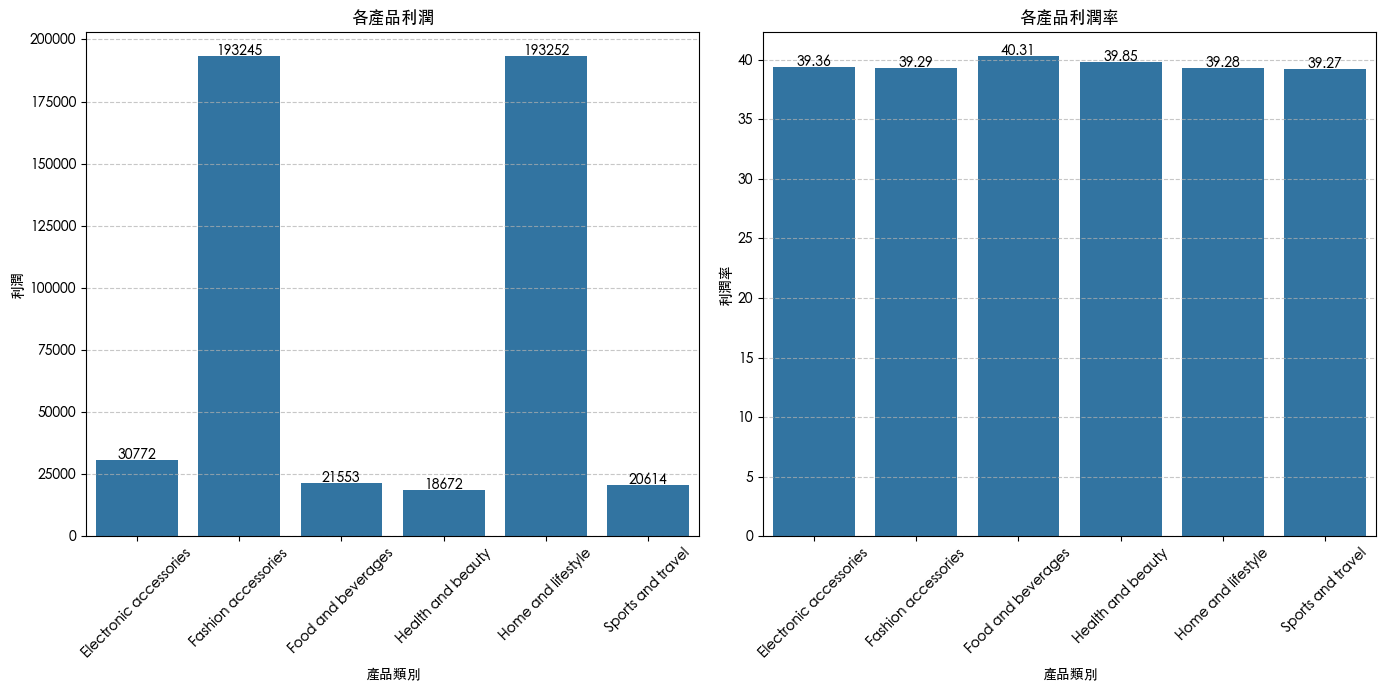

In [3]:
df.head()
df['profit'] = df['total'] * df['profit_margin']
category_performance=df.groupby("category").agg({"total":"sum","quantity":"sum", "profit":"sum","rating":"mean","invoice_id":"nunique"}).reset_index()

#計算各項指標
#利潤率
category_performance["profit_margin"]=category_performance["profit"]/category_performance["total"]*100
#客單價
category_performance["each_transaction"]=category_performance["total"]/category_performance["invoice_id"]
#每單商品數量
category_performance["each_order_qua"]=category_performance["quantity"]/category_performance["invoice_id"]

category_performance.sort_values("profit_margin",ascending=False)



#可視化圖表
#利潤圖表
plt.figure(figsize=(14,7))
ax1=plt.subplot(1,2,1)
sns.barplot(x="category",y="profit",data=category_performance,ax=ax1)
plt.title("各產品利潤")
plt.xlabel("產品類別")
plt.ylabel("利潤")
plt.xticks(rotation=45)
plt.grid(True,axis='y',linestyle='--', alpha=0.7)
for i,v in enumerate(category_performance["profit"]) :
    plt.text(i,v,f"{v:.0f}",ha="center")

#利潤率圖表

ax2=plt.subplot(1,2,2)
sns.barplot(x="category",y="profit_margin",data=category_performance,ax=ax2)
plt.title("各產品利潤率")
plt.xlabel("產品類別")
plt.ylabel("利潤率")
plt.xticks(rotation=45)
plt.grid(True,axis='y',linestyle='--', alpha=0.7)
for i,v in enumerate(category_performance["profit_margin"]) :
    plt.text(i,v,f"{v:.2f}",ha="center")

report=[]
report.append("產品類別綜合表現\n")


print("\n產品類別綜合表現：")
report.append(category_performance[['category', 'total', 'profit', 'profit_margin', 
                          'each_transaction', 'each_order_qua', 'rating']].round(2).to_string(index=False))
report_text = "\n".join(report)
Path("產品類型銷售表現.txt").write_text(report_text,encoding="utf-8")
print(report_text)
plt.tight_layout()
plt.savefig('產品利潤分析.png', dpi=300)




In [4]:
#3.1產品組合分析
category_performance.head()
print(report_text)



產品類別綜合表現

              category     total    profit  profit_margin  each_transaction  each_order_qua  rating
Electronic accessories  78175.03  30772.49          39.36            186.58            3.57    5.91
   Fashion accessories 491833.90 193244.53          39.29            108.38            2.14    5.78
    Food and beverages  53471.28  21552.86          40.31            307.31            5.47    7.11
     Health and beauty  46851.18  18671.73          39.85            308.23            5.62    7.00
    Home and lifestyle 491996.06 193251.61          39.28            108.85            2.14    5.73
     Sports and travel  52497.93  20613.81          39.27            316.25            5.54    6.92


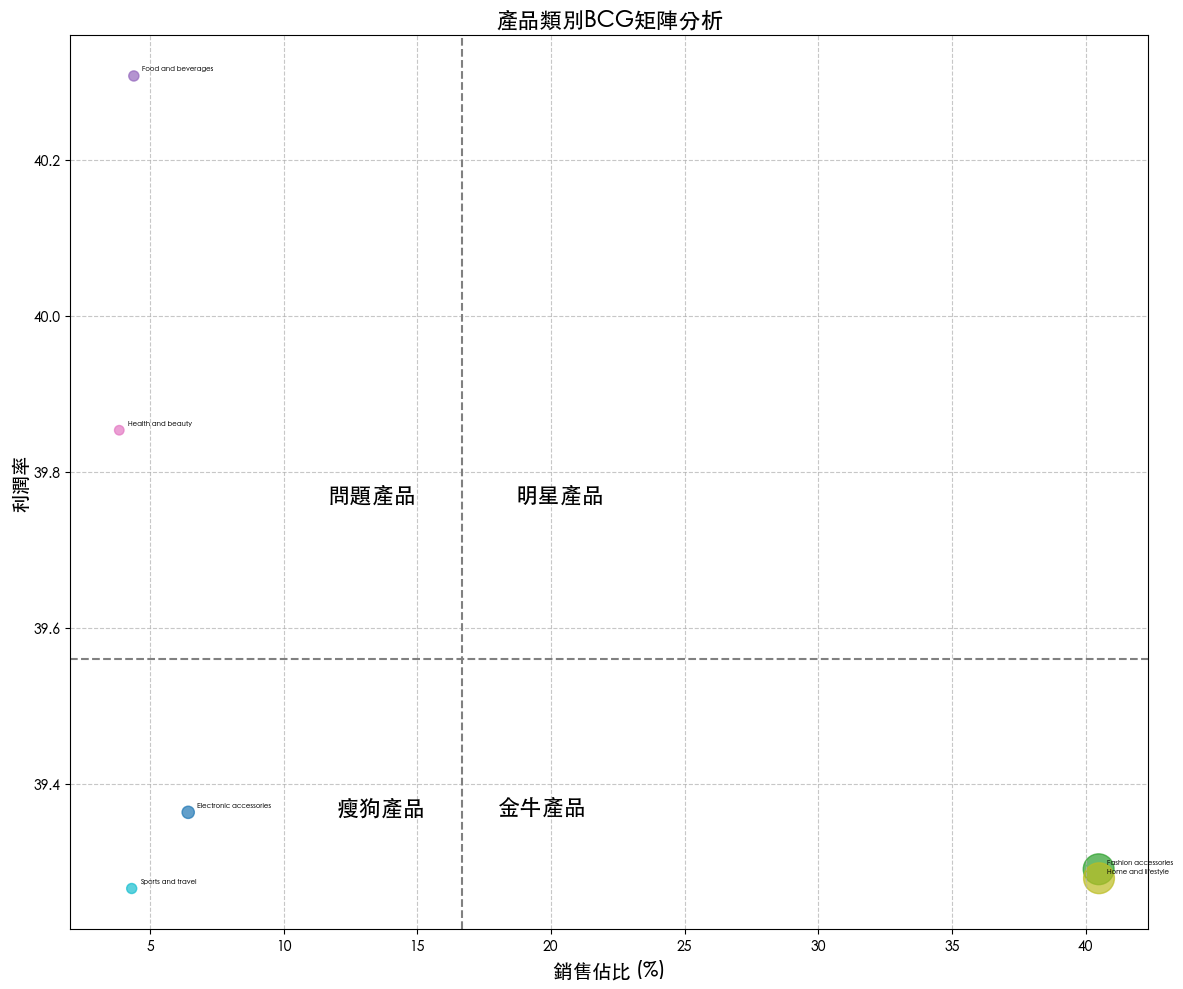

In [5]:
#BCG矩陣圖形把產品分類為明星、利基、拉量型、問題

plt.figure(figsize=(12,10))

#使用銷售佔比和利潤率作為BCG的維度

category_performance["sales_percentage"]=category_performance["total"]/(category_performance["total"].sum())*100
x=category_performance["sales_percentage"]
y=category_performance["profit_margin"]
size=category_performance["total"]/1000

#創造BCG矩陣
plt.scatter(x,y,s=size,alpha=0.7,c=range(len(category_performance)),cmap='tab10')

#創造象限分隔線
xm=x.mean()
ym=y.mean()
plt.axvline(x=xm,color="gray", linestyle='--')
plt.axhline(y=ym,color="gray", linestyle='--')

plt.text(xm + 2, ym + 0.2,"明星產品",fontsize=16)
plt.text(xm - 5, ym + 0.2,"問題產品",fontsize=16)
plt.text(xm + 3, ym - 0.2, "金牛產品", fontsize=16, ha='center')
plt.text(xm - 3, ym - 0.2, "瘦狗產品", fontsize=16, ha='center')


for i,v in enumerate(category_performance["category"]):
    plt.annotate(v,(x[i],y[i]),fontsize=5,xytext=(6, 4), textcoords='offset points')
plt.title('產品類別BCG矩陣分析', fontsize=16, fontweight='bold')
plt.xlabel('銷售佔比 (%)', fontsize=14)
plt.ylabel('利潤率', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("產品類別BCG矩陣分析",dpi=300)



In [44]:
# 原本想以利潤去做銷售分析 發現利潤率差異不大，改爲消費者購物行為去做
df['transac_group'] = pd.qcut(df['total'], 4, labels=['低消費', '中低消費', '中高消費', '高消費'])

#計算 -總銷售額 -總購買數量 -總利潤平均評分 -有多少筆訂單
customer_performance=df.groupby("transac_group").agg({"total":"sum","quantity":"sum","profit":"sum","rating":"mean","invoice_id":"nunique"}).reset_index()

#計算 - 利潤率-單筆訂單的平均商品數量
customer_performance["profit_margin"]=customer_performance["profit"]/customer_performance["total"]
customer_performance["per_order_quan"]=customer_performance["quantity"]/customer_performance["invoice_id"]

report=[]
report.append(customer_performance)
report_text = "\n".join(report)
Path("顧客分級銷售表現.txt").write_text(report_text,encoding="utf-8")
print(report_text)


#視覺化以不同消費層級顧客去看利潤率和銷售額
plt.figure(figsize=(14,10))
plt.subplot(2,1,1)
x=range(len(customer_performance))
width=0.35
plt.bar(x,customer_performance["total"],width,label="銷售額")
plt.bar([i+width for i in x],customer_performance["profit"],width,label="利潤")

plt.title("不同消費層級顧客銷售額和利潤率")
plt.xticks([i + width/2 for i in x],customer_performance["transac_group"])
plt.xlabel("不同消費層級顧客")
plt.ylabel("金額")
plt.legend(loc="upper left")
plt.grid(True,axis="y",linestyle="--",alpha=0.7)

for i,v in enumerate(customer_performance["total"]):
    plt.text(i,v+5000,f'{v:.0f}',ha="center")

for i,v in enumerate(customer_performance["profit"]):
    plt.text(i+width,v+5000,f'{v:.0f}',ha="center")



#視覺化以不同消費層級顧客去看利潤率和銷售額
plt.subplot(2,1,2)
ax1=plt.gca()
ax2=ax1.twinx()


x=range(len(customer_performance))
width=0.35
ax1.bar(x,customer_performance["quantity"],width,label="商品數量")
ax1.set_ylabel("商品數量", color="blue")

ax2.plot(x,customer_performance["rating"],'ro-',linewidth=2,label="滿意度")  
ax2.set_ylabel("平均評分", color="red")

for i,v in enumerate(customer_performance["quantity"]):
    ax1.text(i,v,f'{v:.0f}',ha="center")

plt.title("不同消費層級顧客商品數量和滿意度")
plt.xticks([i for i in x],customer_performance["transac_group"])
ax1.set_xlabel("不同消費層級顧客")
plt.grid(True,axis="y",linestyle="--",alpha=0.7)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.savefig("顧客分級計算",dpi=300)


/var/folders/ch/3q7p7fzx3w92z4v7n4s0n_500000gn/T/ipykernel_47047/2435317850.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  customer_performance=df.groupby("transac_group").agg({"total":"sum","quantity":"sum","profit":"sum","rating":"mean","invoice_id":"nunique"}).reset_index()


TypeError: sequence item 0: expected str instance, DataFrame found

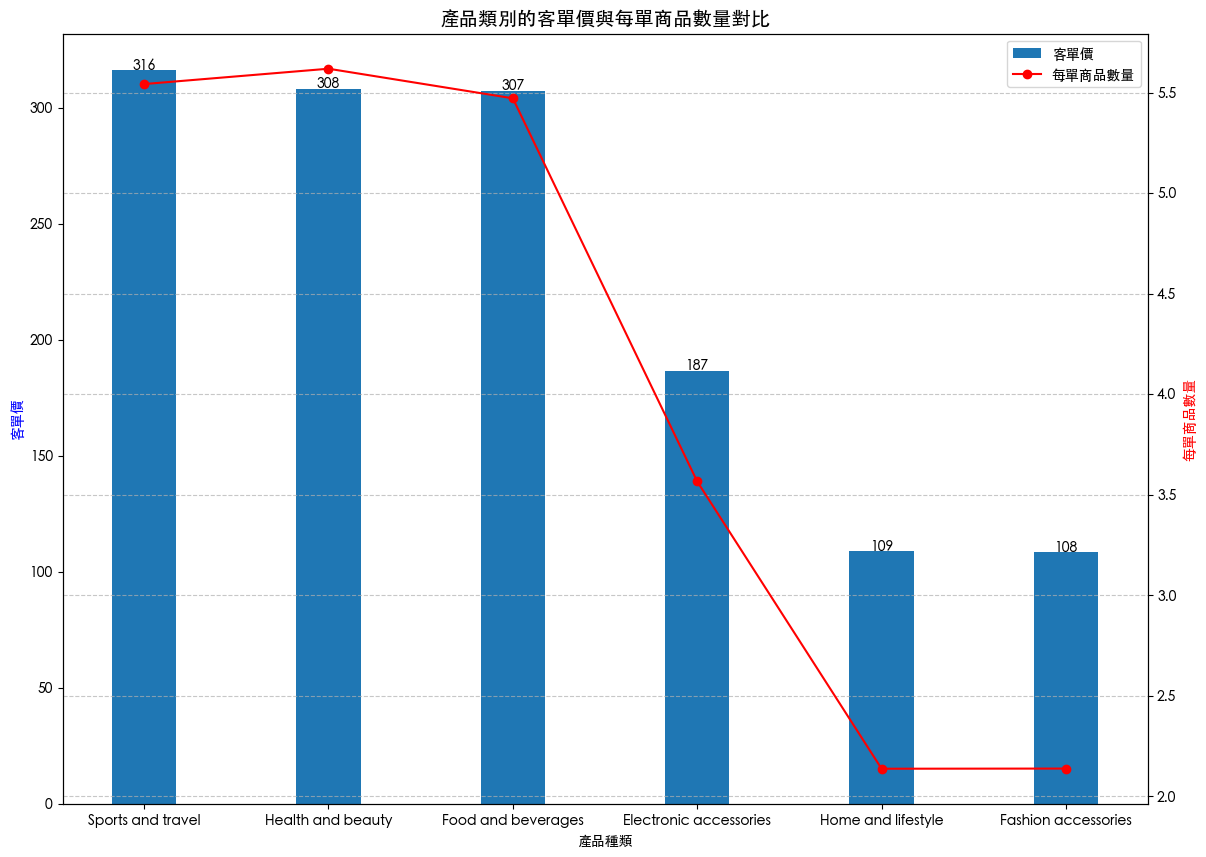

In [40]:
#以產品分類角度去分類

sorted_by_transaction = category_performance.sort_values('each_transaction', ascending=False)

plt.figure(figsize=(14,10))
ax1=plt.gca()
ax2=ax1.twinx()
width=0.35
ax1.bar(sorted_by_transaction["category"],sorted_by_transaction["each_transaction"],width,label="客單價")
ax1.set_ylabel("客單價", color="blue")
ax1.set_xlabel("產品種類")
ax1.set_title("產品類別的客單價與每單商品數量對比",fontsize=14)

ax2.plot(sorted_by_transaction["category"],sorted_by_transaction["each_order_qua"],"ro-",label="每單商品數量")  
ax2.set_ylabel("每單商品數量", color="red")

for i,v in enumerate(sorted_by_transaction["each_transaction"]):
    ax1.text(i,v,f'{v:.0f}',ha="center")

plt.grid(True,axis="y",linestyle="--",alpha=0.7)


line1,label1=ax1.get_legend_handles_labels()
line2,label2=ax2.get_legend_handles_labels()
ax1.legend(line1 + line2, label1 + label2)







In [13]:
sorted_by_transaction.head()

,category,total,quantity,profit,rating,invoice_id,profit_margin,each_transaction,each_order_qua,sales_percentage
5,Sports and travel,52497.93,920,20613.8082,6.916265,166,39.265945,316.252590,5.542169,4.321438
3,Health and beauty,46851.18,854,18671.7345,7.003289,152,39.853285,308.231447,5.618421,3.856618
2,Food and beverages,53471.28,952,21552.8622,7.113218,174,40.307362,307.306207,5.471264,4.401561
0,Electronic accessories,78175.03,1494,30772.4895,5.912172,419,39.363579,186.575251,3.565632,6.435084
4,Home and lifestyle,491996.06,9660,193251.6081,5.733773,4520,39.279097,108.848686,2.137168,40.499323
